In [2]:
from PIL import Image
import numpy as np

In [15]:
img_path = "../data/imgs/0cdf5b5d0ce1_01.jpg"
mask_path = "../data/masks/0cdf5b5d0ce1_01_mask.gif"

In [27]:
img = Image.open(img_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

In [33]:
img = img.resize((200,200))

In [35]:
mask = mask.resize((200,200))

In [41]:
img_np = np.array(img)
mask_np = np.array(mask,dtype=np.float32)
img_np.dtype

dtype('uint8')

In [49]:
print(mask_np[100])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.  15. 229.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1. 120.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 

In [45]:
mask_np[mask_np == 255.0] = 1.0

In [50]:
mask_np[100]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  15., 229.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1., 120.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

(200, 200, 3)
(200, 200, 3)


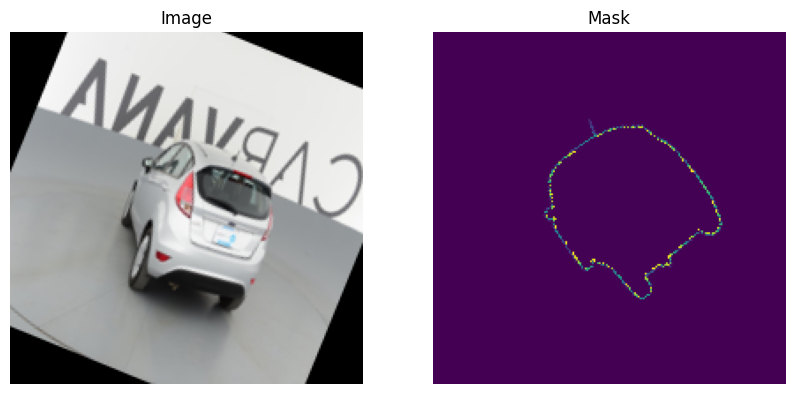

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt

class Caravana(Dataset):
    def __init__(self,image_dir,mask_dir,transforms = None, resize_shape = (200,200)):
        super(Caravana,self).__init__()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms= transforms
        self.resize_shape = resize_shape
        self.images = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_mask.gif")) # as os.listdir returns in an arbitary order
        
        img = Image.open(img_path).convert("RGB").resize(self.resize_shape)
        mask = Image.open(mask_path).convert("L").resize(self.resize_shape)

        img_np = np.array(img)
        mask_np = np.array(mask,dtype=np.float32)
        print(img_np.shape)
        mask_np[mask_np == 255.0] = 1.0

        if self.transforms is not None:
            augmentations = self.transforms(image=img_np, mask=mask_np)
            img_tensor = augmentations["image"]
            mask_tensor = augmentations["mask"]
        
        return img_tensor,mask_tensor


train_transform = A.Compose(
[
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    # this will only divide by 255 (since mean = 0 and std = 1)
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
],
)
dataset = Caravana("../data/imgs","../data/masks",resize_shape=(200,200),transforms=train_transform)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(dataset[0][0].permute(1,2,0)) 
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(dataset[0][1])  
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()  

In [66]:
dataset = Caravana("../data/imgs","../data/masks",resize_shape=(200,200))

In [67]:
len(dataset)

5088

In [72]:
dataset[0][1].shape

(200, 200)

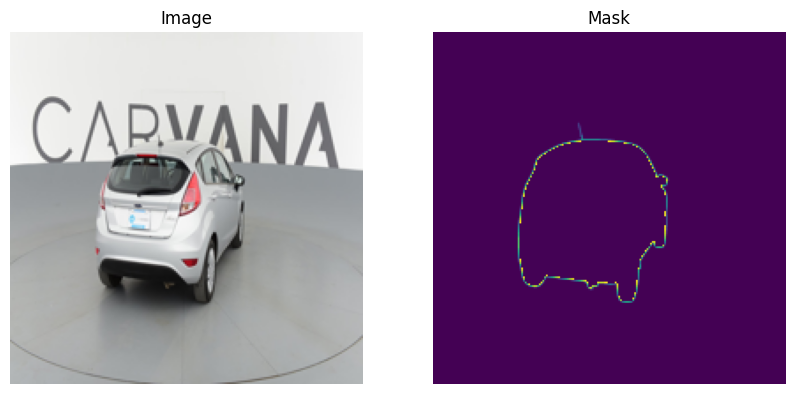

In [79]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(dataset[0][0]) 
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(dataset[0][1])  
axes[1].set_title("Mask")
axes[1].axis("off")

plt.show()  
